In [1]:
import math

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf

import arviz as az
import cvxpy as cp
import pymc as pm
import pytensor.tensor as at
import stan

In [2]:
import sys
sys.path.append('../') # go to parent dir
sys.path.append('/home/artem/git/sdafe')

### Example 20.9. Fitting a t-distribution to returns

In [3]:
data = pd.read_csv('../data/SP500.csv')
data.head()

,r500
0,-0.011727
1,0.002454
2,0.011052
3,0.019051
4,-0.005566


In [4]:
with pm.Model() as model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', mu=0, sigma=1000)
    tau = pm.Gamma('tau', 0.1, 0.01)
    k = pm.Uniform('k', 2, 50)
    sigma2 = 1 / tau
    sigma = pm.Deterministic('sigma', at.sqrt(sigma2))
    # Likelihood for the observed data
    r = pm.StudentT('r', nu=k, mu=mu, sigma=sigma, observed=data['r500'])

In [5]:
with model:
    # draw 1000 posterior samples
    idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, tau, k]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 14 seconds.
/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


The estimates of the parameters, confidence intervals, estimated sample sizes and $\hat{R}$ (potential scale reduction factors):

In [6]:
az.summary(idata, var_names=['k', 'mu', 'sigma'], round_to=6, hdi_prob=0.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,6.020631,0.562526,5.003699,7.165717,0.011282,0.007979,2499.633989,2915.015141,1.000638
mu,0.000519,0.000179,0.000150,0.000854,0.000003,0.000002,4799.627196,3215.884757,1.001438
sigma,0.008406,0.000161,0.008103,0.008733,0.000003,0.000002,2556.404092,2773.351752,1.000139


Arviz offers two model comparison criteria: LOO (leave-one-out) and WAIC (widely-applicable information criterion).

Both require log-likelihood to be computed (it is not computed by default):

In [7]:
with model:
    pm.compute_log_likelihood(idata)

The LOO output:

In [8]:
az.loo(idata)

/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


Computed from 4000 posterior samples and 2783 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  9030.37    49.91
p_loo        3.84        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     2782  100.0%
 (0.5, 0.7]   (ok)          1    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%

The WAIC output:

In [9]:
az.waic(idata)

/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/arviz/stats/stats.py:1645: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


Computed from 4000 posterior samples and 2783 observations log-likelihood matrix.

          Estimate       SE
elpd_waic  9030.41    49.90
p_waic        3.80        -

There has been a warning during the calculation. Please check the results.

Trace plots and posterior densities:

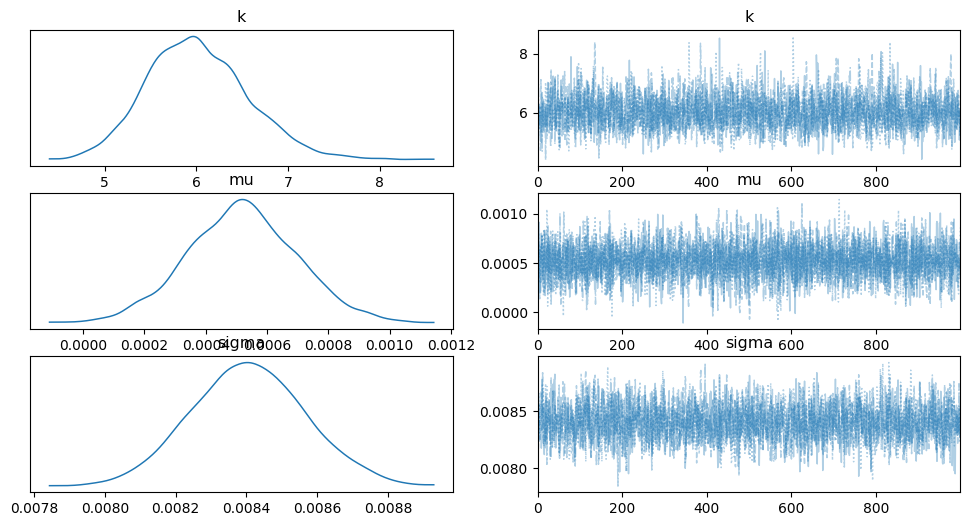

In [10]:
az.plot_trace(idata, var_names=['k', 'mu', 'sigma'], combined=True);

### Example 20.10. Good mixing and poor mixing

In [11]:
rng = np.random.default_rng(90201)

In [12]:
N = 50
beta1 = 1
beta2 = 2
alpha = 1

In [13]:
x1 = rng.normal(3, 2, N)
x2 = x1 + rng.normal(3, 0.2, N)

In [14]:
y = alpha + beta1 * x1 + beta2 * x2 + rng.normal(0, 0.2, N)

In [15]:
with pm.Model() as model:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(1e5), shape=3)
    tau = pm.Gamma('tau', 0.01, 0.01)
    mu = beta[0] + beta[1] * x1 + beta[2] * x2
    sigma = at.sqrt(1 / tau)
    # Likelihood for the observed data
    y_ = pm.Normal('y', mu=mu, sigma=sigma, observed=y)

With the default number of 1000 draws per chain, the sampler achieves good mixing:

In [16]:
with model:
    idata = pm.sample(chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [beta, tau]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 50 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


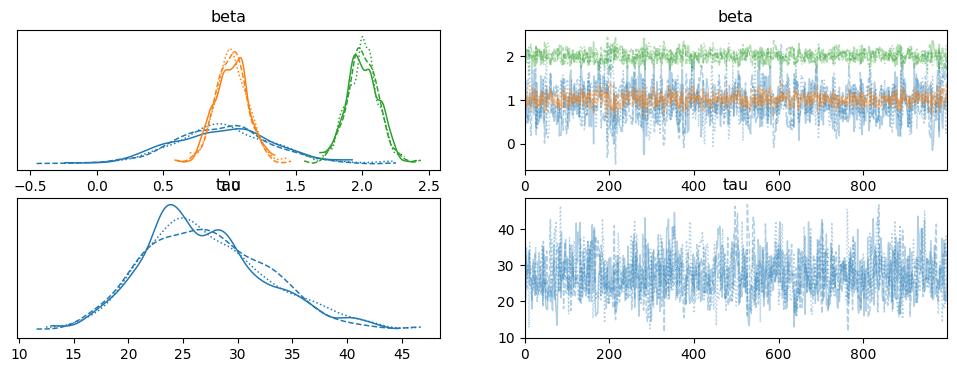

In [17]:
az.plot_trace(idata);

Mixing is pretty good even for a low number of draws, e.g. 100:

Only 100 samples in chain.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [beta, tau]


Sampling 3 chains for 1_000 tune and 100 draw iterations (3_000 + 300 draws total) took 29 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


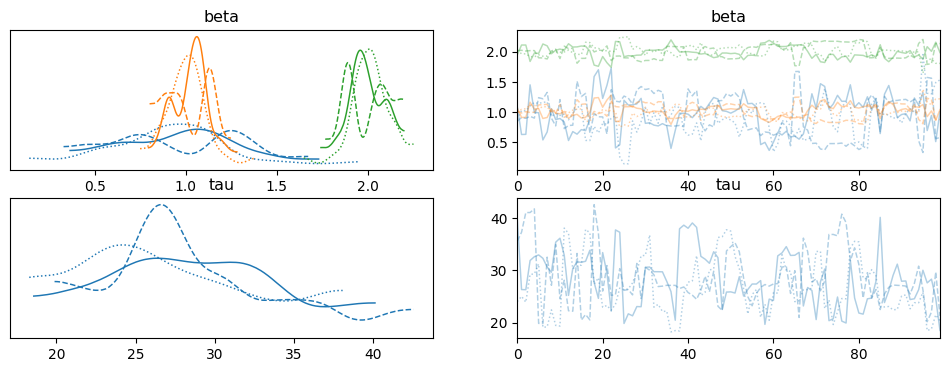

In [18]:
with model:
    idata2 = pm.sample(chains=3, draws=100)
az.plot_trace(idata2);

We can reduce the quality of mixing by lowering the `target_accept` value of the NUTS sampler below the default of 0.9:

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [beta, tau]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 20 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


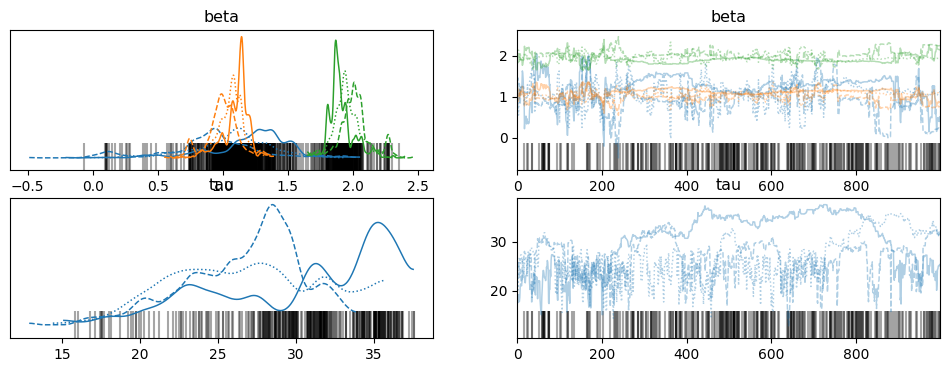

In [19]:
with model:
    idata3 = pm.sample(chains=3, nuts={'target_accept': 0.4})
az.plot_trace(idata3);

#### No collinearity

In [20]:
rng = np.random.default_rng(90201)

In [21]:
x1 = rng.normal(3, 2, N)
x2 = rng.normal(3, 2, N) + rng.normal(3, 0.2, N)

In [22]:
y = alpha + beta1 * x1 + beta2 * x2 + rng.normal(0, 0.2, N)

In [23]:
with pm.Model() as model:
    # Priors for unknown model parameters
    beta = pm.Normal('beta', mu=0, sigma=np.sqrt(1e5), shape=3)
    tau = pm.Gamma('tau', 0.01, 0.01)
    mu = beta[0] + beta[1] * x1 + beta[2] * x2
    sigma = at.sqrt(1 / tau)
    # Likelihood for the observed data
    y_ = pm.Normal('y', mu=mu, sigma=sigma, observed=y)

In [24]:
with model:
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [beta, tau]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 7 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


The posteriors are significantly more concentrated:

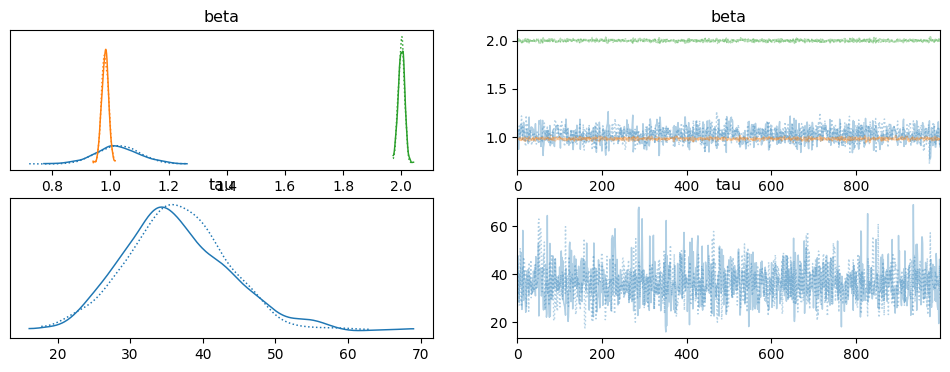

In [25]:
az.plot_trace(idata);

### Example 20.12 Estimating expected returns on midcap stocks

In [26]:
data = pd.read_csv('../data/midcapD.ts.csv', index_col=0, parse_dates=[0])
data.head()

,LSCC,CSGS,EC,NYB,ALTR,APH,CLS,NET,SBUX,AYE,...,SBL,PCZ,OSI,TRP,ROH,SU,MTD,RAD,GUC,market
X.Y..m..d,,,,,,,,,,,,,,,,,,,,,
2000-01-03,0.031167,0.051724,-0.019868,-0.009217,0.058008,0.010329,-0.040541,-0.016393,0.016753,-0.037123,...,-0.000983,-0.021739,-0.019277,0.007143,-0.007680,-0.017964,-0.073650,0.067416,0.002183,-0.007124
2000-01-04,-0.075241,-0.023845,-0.050676,-0.032558,-0.050060,-0.034387,-0.115023,-0.064286,-0.031686,0.012048,...,-0.083661,-0.017778,0.007371,-0.014184,-0.017028,0.033537,-0.021201,-0.042105,-0.032135,-0.039521
2000-01-05,-0.025730,-0.003053,0.021352,-0.002404,-0.011292,-0.022137,-0.071618,0.012723,0.013089,0.045238,...,-0.066595,0.063348,0.000000,0.000000,0.061417,0.085546,-0.021661,-0.021978,-0.018571,-0.000856
2000-01-06,-0.049251,-0.050536,0.027875,0.002410,-0.025381,-0.027559,0.002857,-0.042714,0.036176,-0.009112,...,-0.024166,-0.021277,-0.004878,0.000000,0.037092,-0.027174,0.022140,-0.033708,-0.018349,-0.007353
2000-01-07,0.041291,-0.008065,0.013559,0.002404,0.104167,0.010121,0.048433,0.055118,-0.004988,0.002299,...,-0.003538,-0.004348,-0.031863,-0.035971,0.072961,0.006983,0.028881,0.023256,0.032710,0.032511


In [27]:
market = 100 * data.iloc[:, -1]
x = 100 * data.iloc[:, :-1]

In [28]:
m = 20
k = 100

In [29]:
x1 = x.iloc[1:k, :]
x2 = x.iloc[k:501, :]

In [30]:
mu1 = x1.mean()
mu2 = x2.mean()
means = mu1
sd = x1.std()

In [31]:
with pm.Model(coords={"predictors": x1.columns.values}) as model:
    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sigma=np.sqrt(1e3))
    tau_eps = pm.Gamma('tau_eps', 0.1, 0.01)
    tau_mu = pm.Gamma('tau_mu', 0.1, 0.01)
    sigma_eps = 1 / at.sqrt(tau_eps)
    sigma_mu = 1 / at.sqrt(tau_mu)
    mu = pm.Normal("mu", mu=alpha, sigma=sigma_mu, dims='predictors')
    # Likelihood for the observed data
    y_ = pm.Normal('y', mu=mu, sigma=sigma_eps, observed=x1)

In [32]:
with model:
    idata = pm.sample(chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 2 jobs)
NUTS: [alpha, tau_eps, tau_mu, mu]


Sampling 3 chains for 1_000 tune and 1_000 draw iterations (3_000 + 3_000 draws total) took 18 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


In [33]:
summ = az.summary(idata, round_to=4)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.0812,0.1076,-0.1195,0.2757,0.0061,0.0043,309.6910,525.9369,1.0160
mu[LSCC],0.0991,0.1728,-0.2493,0.4016,0.0064,0.0045,709.8358,1403.7125,1.0068
mu[CSGS],0.1103,0.1700,-0.2120,0.4228,0.0064,0.0046,677.4145,1373.9138,1.0047
mu[EC],0.0748,0.1674,-0.2226,0.4085,0.0056,0.0042,845.3670,1376.5570,1.0079
mu[NYB],0.0428,0.1716,-0.2783,0.3633,0.0062,0.0044,714.5774,1745.1039,1.0031
mu[ALTR],0.1352,0.1738,-0.1991,0.4697,0.0073,0.0052,553.6067,1213.3124,1.0080
mu[APH],0.1156,0.1716,-0.1920,0.4442,0.0063,0.0044,696.6110,1612.6778,1.0075
mu[CLS],0.0458,0.1679,-0.2719,0.3603,0.0060,0.0042,745.6506,1615.1023,1.0062
mu[NET],0.0631,0.1724,-0.2675,0.3751,0.0058,0.0041,845.2010,1572.0651,1.0036
mu[SBUX],0.1089,0.1692,-0.2066,0.4296,0.0068,0.0048,602.5331,1425.8586,1.0080


In [34]:
np.sum((mu1 - mu2) ** 2)

1.8344708825648284

In [35]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [36]:
post_means = summ.iloc[1:-2, 0]
np.sum((post_means.values - mu2.values) ** 2)

0.16829276086674064

In [37]:
np.sum((np.mean(mu1) - mu2) ** 2)

0.11473649084390436

In [38]:
def plot_comparison(ax, estimates, targets, title):
    ax.scatter([1] * m + [2] * m, np.concatenate([estimates, targets]), edgecolors='black', facecolors='none');
    for i in range(len(estimates)):
        ax.plot([1, 2], [estimates[i], targets[i]]);
    ax.set_title(title);
    ax.set_xticks([1, 2]);
    ax.set_xticklabels(['estimate', 'target']);

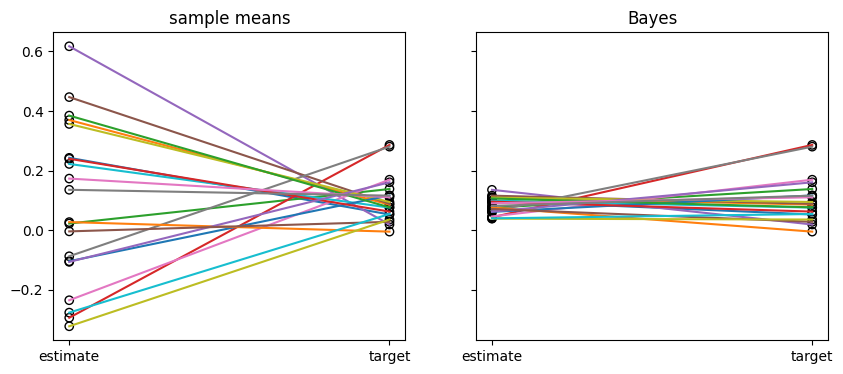

In [39]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
plot_comparison(axs[0], mu1, mu2, 'sample means');
plot_comparison(axs[1], post_means, mu2, 'Bayes');

### Example 20.13. Estimating the correlation matrix of the CRSPday data

In [40]:
data = pd.read_csv('../data/CRSPday.csv', usecols=range(1, 8), parse_dates=[[0, 1, 2]], index_col=0)
data.head()

,ge,ibm,mobil,crsp
year_month_day,,,,
1989-01-03,-0.016760,0.000000,-0.002747,-0.007619
1989-01-04,0.017045,0.005128,0.005510,0.013016
1989-01-05,-0.002793,-0.002041,0.005479,0.002815
1989-01-06,0.000000,-0.006135,0.002725,0.003064
1989-01-09,0.000000,0.004115,0.005435,0.001633


In [41]:
N, m = data.shape

In [42]:
mu0 = np.zeros(m)
Sigma_mu0 = np.eye(m) * np.sqrt(10000)
Sigma0 = np.eye(m) * np.sqrt(10000)
eta_Sigma = 6
df_likelihood = 6
df_prior = 6

In [43]:
with pm.Model(coords={'predictors': data.columns.values}) as model:
    # Priors for unknown model parameters
    mu = pm.MvStudentT('mu', nu=df_prior, mu=mu0, scale=Sigma_mu0, dims='predictors')
    sd_dist = pm.Exponential.dist(1.0, size=m)
    packed_chol = pm.LKJCholeskyCov('chol', eta=eta_Sigma, n=m, sd_dist=sd_dist, compute_corr=False)
    chol = pm.expand_packed_triangular(m, packed_chol, lower=True)
    Sigma = pm.Deterministic('Sigma', at.dot(chol, chol.T))
    # Likelihood for the observed data
    y_ = pm.MvStudentT('y', nu=df_likelihood, mu=mu, chol=chol, observed=data)

In [44]:
with model:
    idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [mu, chol]


/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/pytensor/compile/function/types.py:970: RuntimeWarning: invalid value encountered in accumulate
  self.vm()
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 465 seconds.


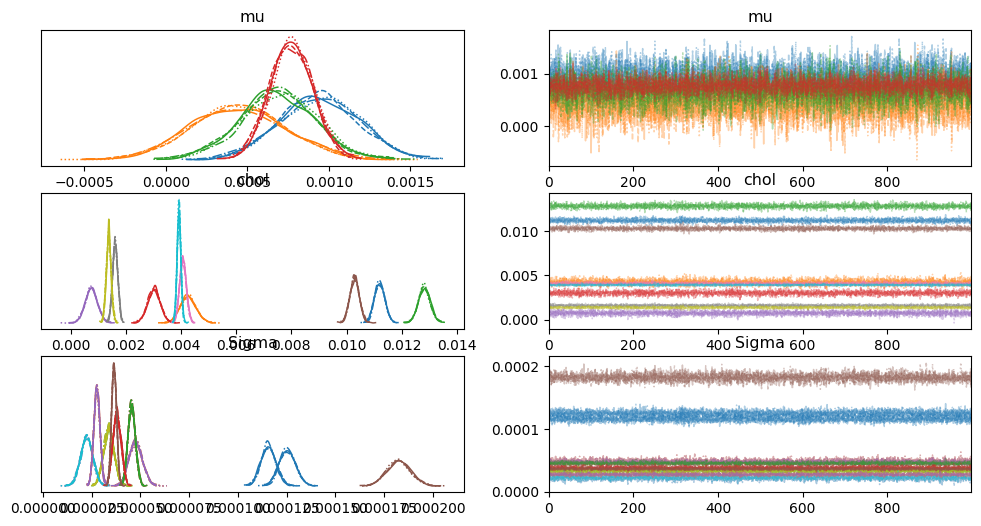

In [45]:
az.plot_trace(idata);

In [46]:
summ = az.summary(idata, round_to=5)
summ

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu[ge],0.00094,0.00024,0.00048,0.00139,0.0,0.0,4317.64069,3666.95838,1.00022
mu[ibm],0.00044,0.00029,-0.00009,0.00099,0.0,0.0,5419.17393,3698.74330,1.00163
mu[mobil],0.00069,0.00023,0.00023,0.00111,0.0,0.0,6139.10879,3314.01015,1.00043
mu[crsp],0.00077,0.00013,0.00053,0.00102,0.0,0.0,3662.00618,3501.56141,1.00121
chol[0],0.01120,0.00019,0.01086,0.01156,0.0,0.0,5393.43618,3688.11549,1.00119
chol[1],0.00426,0.00028,0.00374,0.00482,0.0,0.0,6292.01445,3389.53257,1.00032
chol[2],0.01282,0.00021,0.01241,0.01321,0.0,0.0,6299.44349,3299.25777,1.00064
chol[3],0.00302,0.00023,0.00262,0.00347,0.0,0.0,6794.39546,2924.67963,0.99960
chol[4],0.00075,0.00022,0.00033,0.00115,0.0,0.0,7679.92448,2782.24698,1.00000
chol[5],0.01029,0.00017,0.00998,0.01061,0.0,0.0,6381.99874,3026.72585,1.00018


In [47]:
cov = summ.iloc[14:, 0].values.reshape(m, m)
s = np.diag(1 / np.sqrt(np.diag(cov)))
corr = s @ cov @ s

In [48]:
pd.DataFrame(corr, index=data.columns, columns=data.columns)

,ge,ibm,mobil,crsp
ge,1.000000,0.326860,0.240192,0.693375
ibm,0.326860,1.000000,0.136083,0.471405
mobil,0.240192,0.136083,1.000000,0.433013
crsp,0.693375,0.471405,0.433013,1.000000


In [49]:
data.corr()

,ge,ibm,mobil,crsp
ge,1.000000,0.333598,0.297250,0.714822
ibm,0.333598,1.000000,0.158707,0.486364
mobil,0.297250,0.158707,1.000000,0.429395
crsp,0.714822,0.486364,0.429395,1.000000


### Example 20.14. Fitting an ARMA(1,1) stochastic volatility model to the S&P 500 stock returns

In [50]:
data = pd.read_csv('../data/S&P500_new.csv', index_col=0, parse_dates=[0])
data.head()

,Open,High,Low,Close,Volume,Adj Close
Date,,,,,,
2011-01-03,1257.62,1276.17,1257.62,1271.87,4286670000,1271.87
2011-01-04,1272.95,1274.12,1262.66,1270.20,4796420000,1270.20
2011-01-05,1268.78,1277.63,1265.36,1276.56,4764920000,1276.56
2011-01-06,1276.29,1278.17,1270.43,1273.85,4844100000,1273.85
2011-01-07,1274.41,1276.83,1261.70,1271.50,4963110000,1271.50


In [51]:
prices = data['Adj Close']
y = np.log(prices).diff().dropna()

#### PyMC

Attempting to run this model with PyMC hits the recursion limit - this needs to be investigated further.

In [52]:
with pm.Model() as sv_model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', 0, 1)
    beta0 = pm.Normal('beta0', 0, 100)
    phi = pm.Normal('phi', 0.4, 100)
    theta = pm.Normal('theta', 0, 100)
    tau_v = pm.Gamma('tau_v', 0.01, 0.01)
    nu = pm.Uniform('nu', 1, 30)
    sigma_v = 1 / at.sqrt(tau_v)
    
    v = pm.Normal('v', 0, sigma_v, shape=y.shape[0])
    logh = pm.Normal('logh[1]', 0, 1000)
    h = pm.Deterministic(f'h[1]', at.exp(logh))
    
    # likelihood for the first observation
    pm.StudentT(f'y[1]', nu=nu, mu=mu, sigma=at.sqrt(h), observed=y[0])
    
    for i in range(1, y.shape[0]):
        logh_mu = beta0 + phi * logh + theta * v[i - 1]
        logh = logh_mu + v[i]
        h = at.exp(logh)

        # likelihood for the second and subsequent observations
        pm.StudentT(f'y[{i+1}]', nu=nu, mu=mu, sigma=at.sqrt(h), observed=y[i])

In [53]:
#pm.model_to_graphviz(model)

In [54]:
#%%time
#with sv_model:
#    idata = pm.sample(chains=4)

#### PyStan

In [55]:
import nest_asyncio
nest_asyncio.apply()

In [56]:
model_sv = """
data {
  int<lower=0> T;
  vector[T] y;
}
parameters {
  real mu;
  real beta0;
  real<lower=-1, upper=1> phi;
  real<lower=-1, upper=1> theta;
  real<lower=1> nu;
  vector[T] v;
  real<lower=0> tau_v;
  real logh1;
}
transformed parameters {
  real<lower=0> sigma_v = 1 / sqrt(tau_v);

  vector[T] logh;
  logh[1] = logh1;
  for (t in 2:T) {
    logh[t] = beta0 + phi * logh[t-1] + theta * v[t-1] + v[t];
  }
  
  vector[T] h = exp(logh / 2);
}
model {
  mu ~ normal(0, 1);
  beta0 ~ normal(0, 100);
  phi ~ normal(0.4, 100);
  theta ~ normal(0, 100);
  tau_v ~ gamma(0.01, 0.01);
  nu ~ uniform(1, 30);
  
  v ~ normal(0, sigma_v);
  logh1 ~ normal(0, 1000);

  y ~ student_t(nu, mu, h);
}
"""

In [57]:
data = {
    'y': y.values,
    'T': y.shape[0],
}

In [58]:
posterior_sv = stan.build(model_sv, data=data);
fit_sv = posterior_sv.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_3l5g5in8/model_bfv4q7nr.stan', line 36, column 20: Argument
    1000 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_3l5g5in8/model_bfv4q7nr.stan', line 33, column 18: Argument
    30 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_3l5g5in8/model_bfv4q7nr.stan', line 33, column 2: Parameter
    nu is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend sof

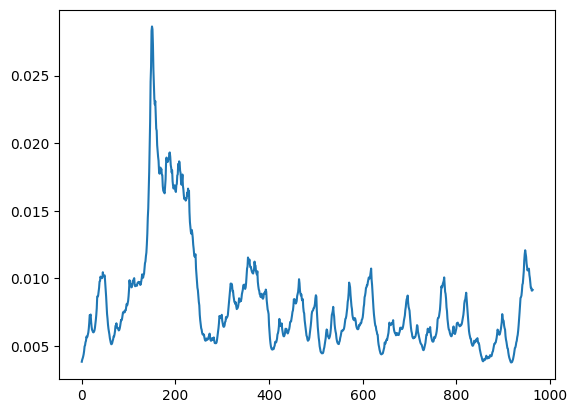

In [59]:
fig, ax = plt.subplots()
ax.plot(np.mean(fit_sv['h'], axis=1));

### Example 20.15. Fitting a GARCH(1,1) model to the S&P 500 stock returns

#### PyMC

Attempting to run this model with PyMC hits the recursion limit - this needs to be investigated further.

In [60]:
with pm.Model() as garch_model:
    # Priors for unknown model parameters
    mu = pm.Normal('mu', 0, np.sqrt(1000))
    alpha0 = pm.Uniform('alpha0', 0, 0.2)
    alpha1 = pm.Uniform('alpha1', 0.00001, 0.8)
    beta1 = pm.Uniform('beta1', 0.00001, 0.8) 
    nu = pm.Uniform('nu', 1, 30)
    tau_eps = pm.Gamma('tau_eps', 0.01, 0.01)
    sigma_eps = 1 / at.sqrt(tau_eps)
    
    eps = pm.StudentT('eps', nu=nu, mu=0, sigma=sigma_eps, shape=y.shape[0])
    h = pm.Uniform('h[1]', 0, 0.0012)
    
    for i in range(y.shape[0]):
        a = at.sqrt(h) * eps[i]

        # likelihood for the second and subsequent observations
        pm.StudentT(f'y[{i+1}]', nu=nu, mu=mu, sigma=a, observed=y[i])
        
        # update h for the next iteration
        h = alpha0 + alpha1 * a**2 + beta1 * h

In [61]:
#%%time
#with garch_model:
#    idata_garch = pm.sample(chains=4)

#### PyStan

In [62]:
model_garch = """
data {
  int<lower=0> T;
  vector[T] y;
}
parameters {
  real mu;
  real<lower=0> sigma1;
  real<lower=0> alpha0;
  real<lower=0, upper=1> alpha1;
  real<lower=0, upper=(1-alpha1)> beta1;
  real<lower=1> nu;
}
transformed parameters {
  array[T] real<lower=0> sigma;
  sigma[1] = sigma1;
  for (t in 2:T) {
    sigma[t] = sqrt(alpha0 + alpha1 * square(y[t-1] - mu) + beta1 * square(sigma[t-1]));
  }  
}
model {
  mu ~ normal(0, sqrt(1000));
  sigma1 ~ gamma(3, 20);
  alpha0 ~ uniform(0, 0.2);
  alpha1 ~ uniform(0.00001, 0.8);
  beta1 ~ uniform(0.00001, 0.8);
  nu ~ uniform(1, 30);
  y ~ student_t(nu, mu, sigma);
}
"""

In [63]:
posterior_garch = stan.build(model_garch, data=data);
fit_garch = posterior_garch.sample(num_chains=4, num_samples=1000)

Building: found in cache, done.
Messages from stanc:
Warning in '/tmp/httpstan_htdl1ffn/model_ssvg5w6w.stan', line 27, column 18: Argument
    30 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
Warning in '/tmp/httpstan_htdl1ffn/model_ssvg5w6w.stan', line 27, column 2: Parameter
    nu is given a uniform distribution. The uniform distribution is not
    recommended, for two reasons: (a) Except when there are logical or
    physical constraints, it is very unusual for you to be sure that a
    parameter will fall inside a specified range, and (b) The infinite
    gradient induced by a uniform density can cause difficulties for Stan's
    sampling algorithm. As a consequence, we recommend soft constraints
    rather than hard constraints; for example, instead of giving an
    elasticity parameter a uniform(0,1) distribution, try normal(0.5,0.5).
Warning in '/tmp/httpstan_htdl1ffn/model_ssvg5w6w.stan', line 26,

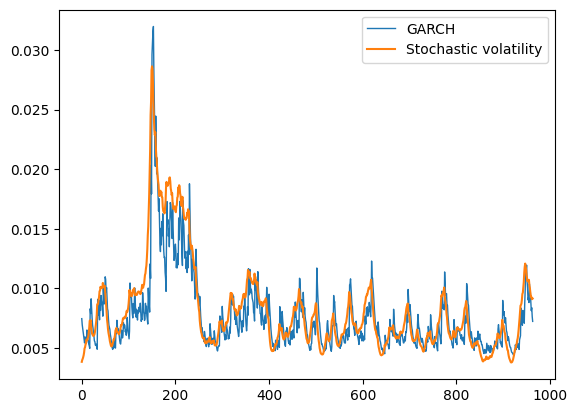

In [64]:
fig, ax = plt.subplots()
ax.plot(np.mean(fit_garch['sigma'], axis=1), linewidth=1, label='GARCH');
ax.plot(np.mean(fit_sv['h'], axis=1), label='Stochastic volatility');
ax.legend();

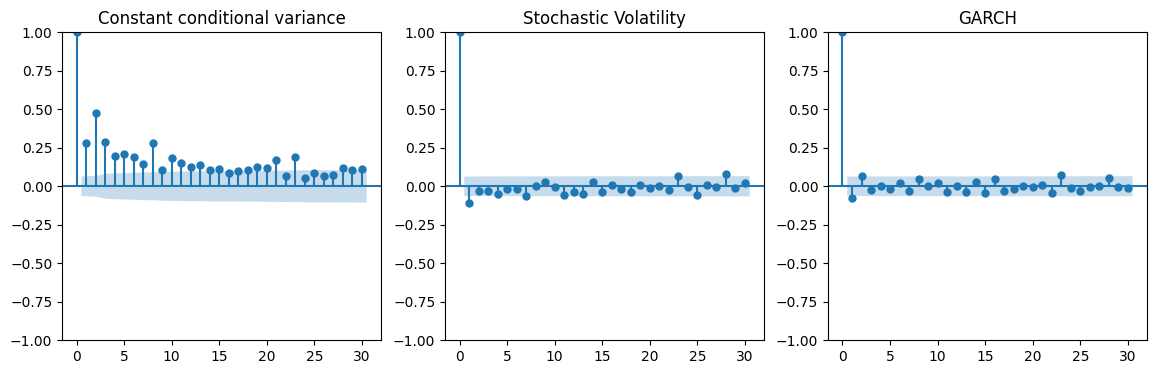

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4))

plot_acf((y - y.mean()) ** 2, ax=axs[0]);
axs[0].set_title('Constant conditional variance');

plot_acf((y - y.mean()) ** 2 / np.mean(fit_sv['h'], axis=1) ** 2, ax=axs[1]);
axs[1].set_title('Stochastic Volatility');

plot_acf((y - y.mean()) ** 2 / np.mean(fit_garch['sigma'], axis=1) ** 2, ax=axs[2]);
axs[2].set_title('GARCH');

### Example 20.16. Fitting a one factor model to stock returns

In [66]:
data = pd.read_csv('../data/Stock_Bond.csv', parse_dates=[0], index_col=0, date_format='%d-%b-%y')
data.head()

,GM_Volume,GM_AC,F_Volume,F_AC,UTX_Volume,UTX_AC,CAT_Volume,CAT_AC,MRK_Volume,MRK_AC,...,XOM_Volume,XOM_AC,S&P_AC,S&P_Volume,1 year Treasury Constant Maturity Rate,3-Year Treasury Constant Maturity Rate,10 year Treasury Constant Maturity Rate,30 year Treasury Constant Maturity Rate,Aaa Bond Yield,Baa Bond Yield
Date,,,,,,,,,,,,,,,,,,,,,
1987-01-02,922200,11.45,2540100,2.31,1130400,3.66,1218400,3.38,14454000,4.02,...,3611200,4.52,246.45,91880000,5.86,6.48,7.18,7.44,8.49,9.97
1987-01-05,2100000,11.73,8670000,2.40,3032800,3.70,1752000,3.48,11538000,4.10,...,9040000,4.63,252.19,181900000,5.85,6.41,7.08,7.35,8.44,9.90
1987-01-06,2720000,11.77,6992000,2.43,6614400,3.74,1206400,3.48,14279400,4.07,...,7931200,4.62,252.78,189300000,5.85,6.42,7.08,7.36,8.41,9.86
1987-01-07,2000400,11.83,7621200,2.53,4233600,3.78,2188000,3.45,13003200,4.08,...,5351200,4.61,255.33,190900000,5.78,6.37,7.05,7.33,8.40,9.82
1987-01-08,2460000,11.66,5807500,2.51,3816800,3.82,2195200,3.44,16320600,4.13,...,9680000,4.61,257.28,194500000,5.78,6.36,7.04,7.31,8.37,9.76


In [67]:
y = data.iloc[:, [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 20]]
n = y.shape[0]
m = y.shape[1] - 1
r = y.pct_change().dropna()

In [68]:
k1 = 250
k2 = k1 + 250

In [69]:
r_train = r.iloc[:k1, :m]
mkt_train = r.iloc[:k1, m]
r_test = r.iloc[k1:k2, :m]

In [70]:
with pm.Model(coords={'predictors': r_train.columns.values}) as model:
    # Priors for unknown model parameters
    meanbeta = pm.Normal('meanbeta', 1, 1000)
    taubeta = pm.Uniform('taubeta', 1, 100)
    beta = pm.Normal('beta', meanbeta, tau=taubeta, shape=(1, m))
    tau = pm.Gamma('tau', 0.1, 0.001, shape=(1, m))
    # Likelihood for the observed data
    R_ = pm.Normal('R', mu=beta * mkt_train.values.reshape(-1, 1), tau=tau, observed=r_train)

In [71]:
with model:
    idata = pm.sample(chains=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 2 jobs)
NUTS: [meanbeta, taubeta, beta, tau]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


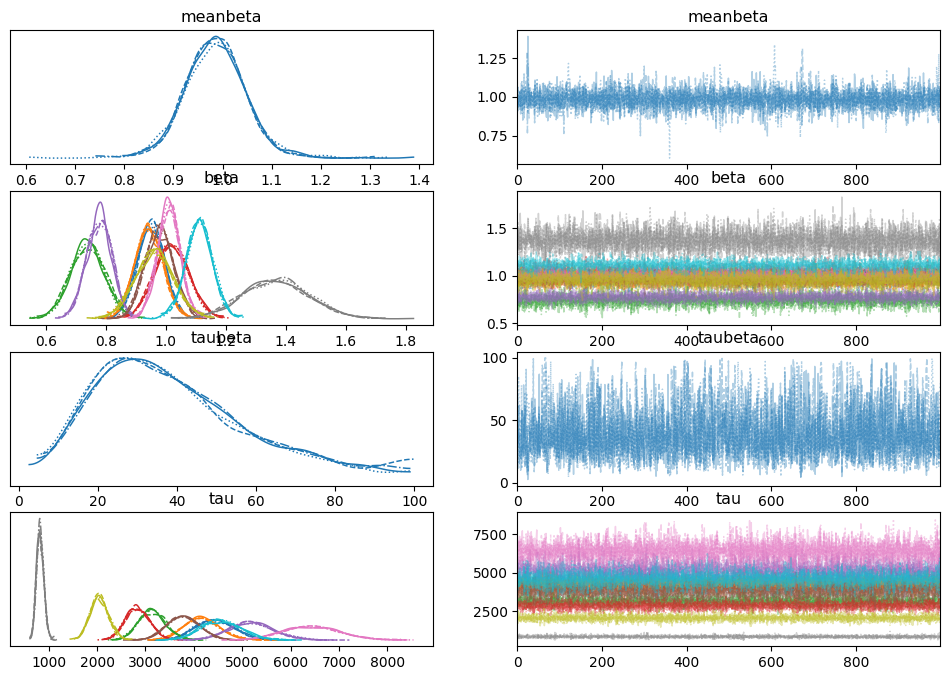

In [72]:
az.plot_trace(idata);

In [73]:
summ = az.summary(idata, hdi_prob=0.95)
summ

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
meanbeta,0.985,0.062,0.864,1.106,0.001,0.001,5934.0,2656.0,1.0
"beta[0, 0]",0.950,0.045,0.861,1.040,0.000,0.000,8280.0,2997.0,1.0
"beta[0, 1]",0.943,0.047,0.855,1.040,0.000,0.000,10547.0,2741.0,1.0
"beta[0, 2]",0.739,0.056,0.630,0.851,0.001,0.000,10051.0,2875.0,1.0
"beta[0, 3]",1.019,0.057,0.907,1.128,0.001,0.000,9604.0,3118.0,1.0
"beta[0, 4]",0.778,0.041,0.693,0.855,0.000,0.000,8915.0,3276.0,1.0
"beta[0, 5]",0.978,0.047,0.891,1.073,0.000,0.000,11561.0,2843.0,1.0
"beta[0, 6]",1.010,0.038,0.934,1.086,0.000,0.000,10083.0,2656.0,1.0
"beta[0, 7]",1.368,0.109,1.162,1.588,0.002,0.001,4733.0,3368.0,1.0
"beta[0, 8]",0.962,0.064,0.833,1.082,0.001,0.000,9311.0,3028.0,1.0


In [74]:
beta = summ.iloc[1:11, 0]
beta

beta[0, 0]    0.950
beta[0, 1]    0.943
beta[0, 2]    0.739
beta[0, 3]    1.019
beta[0, 4]    0.778
beta[0, 5]    0.978
beta[0, 6]    1.010
beta[0, 7]    1.368
beta[0, 8]    0.962
beta[0, 9]    1.112
Name: mean, dtype: float64

In [75]:
beta_lr = np.fromiter((sm.OLS(r_train.iloc[:, i], sm.add_constant(mkt_train)).fit().params[1] for i in range(m)), float)
beta_lr

array([0.94701767, 0.9374398 , 0.70934303, 1.0233229 , 0.76234029,
       0.97806712, 1.01046124, 1.5314797 , 0.95744078, 1.12114015])

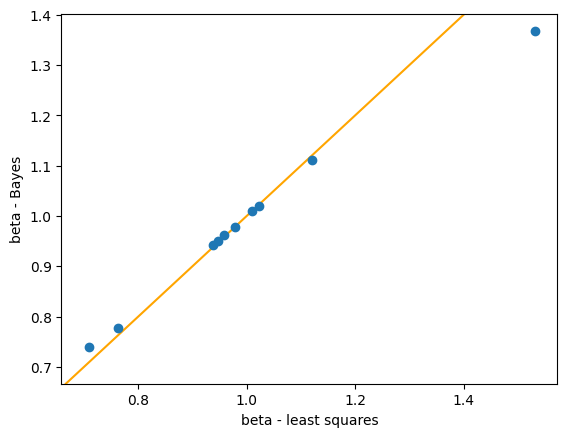

In [76]:
fig, ax = plt.subplots()
ax.axline((0.7, 0.7), (1, 1), color='orange');
ax.plot(beta_lr, beta, 'o');
ax.set_xlabel('beta - least squares');
ax.set_ylabel('beta - Bayes');

In [77]:
sigma_eps = 1 / np.sqrt(summ.iloc[12:, 0])
sigma_eps

tau[0, 0]    0.015014
tau[0, 1]    0.015489
tau[0, 2]    0.017844
tau[0, 3]    0.018760
tau[0, 4]    0.013880
tau[0, 5]    0.016254
tau[0, 6]    0.012470
tau[0, 7]    0.034789
tau[0, 8]    0.022083
tau[0, 9]    0.014789
Name: mean, dtype: float64

Model-free estimates of means and covariances:

In [78]:
mu_model_free = r_train.mean()
mu_model_free

GM_AC      0.000244
F_AC       0.001596
UTX_AC    -0.001027
CAT_AC     0.002055
MRK_AC     0.001126
PFE_AC    -0.000519
IBM_AC     0.000224
MSFT_AC    0.004546
C_AC      -0.001735
XOM_AC     0.000813
dtype: float64

In [79]:
Omega_model_free = r_train.cov()
Omega_model_free

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC,PFE_AC,IBM_AC,MSFT_AC,C_AC,XOM_AC
GM_AC,0.000588,0.000418,0.000273,0.000344,0.000260,0.000373,0.000452,0.000570,0.000268,0.000500
F_AC,0.000418,0.000593,0.000288,0.000429,0.000290,0.000413,0.000405,0.000594,0.000358,0.000408
UTX_AC,0.000273,0.000288,0.000517,0.000341,0.000242,0.000274,0.000265,0.000374,0.000321,0.000300
CAT_AC,0.000344,0.000429,0.000341,0.000773,0.000348,0.000427,0.000394,0.000695,0.000501,0.000373
MRK_AC,0.000260,0.000290,0.000242,0.000348,0.000424,0.000324,0.000292,0.000503,0.000325,0.000297
PFE_AC,0.000373,0.000413,0.000274,0.000427,0.000324,0.000651,0.000408,0.000609,0.000399,0.000438
IBM_AC,0.000452,0.000405,0.000265,0.000394,0.000292,0.000408,0.000569,0.000658,0.000339,0.000497
MSFT_AC,0.000570,0.000594,0.000374,0.000695,0.000503,0.000609,0.000658,0.002142,0.000604,0.000656
C_AC,0.000268,0.000358,0.000321,0.000501,0.000325,0.000399,0.000339,0.000604,0.000856,0.000327
XOM_AC,0.000500,0.000408,0.000300,0.000373,0.000297,0.000438,0.000497,0.000656,0.000327,0.000730


CAPM estimates of means and covariances:

In [80]:
mu_Capm = beta * mkt_train.mean()
mu_Capm

beta[0, 0]    0.000179
beta[0, 1]    0.000178
beta[0, 2]    0.000139
beta[0, 3]    0.000192
beta[0, 4]    0.000147
beta[0, 5]    0.000185
beta[0, 6]    0.000191
beta[0, 7]    0.000258
beta[0, 8]    0.000182
beta[0, 9]    0.000210
Name: mean, dtype: float64

In [81]:
Omega_Capm = pd.DataFrame(
    beta.values.reshape(-1, 1) @ beta.values.reshape(1, -1) * mkt_train.var() + np.diag(sigma_eps ** 2),
    index=r_train.columns, columns=r_train.columns
)
Omega_Capm

,GM_AC,F_AC,UTX_AC,CAT_AC,MRK_AC,PFE_AC,IBM_AC,MSFT_AC,C_AC,XOM_AC
GM_AC,0.000598,0.000370,0.000290,0.000400,0.000305,0.000384,0.000396,0.000537,0.000377,0.000436
F_AC,0.000370,0.000607,0.000288,0.000397,0.000303,0.000381,0.000393,0.000533,0.000375,0.000433
UTX_AC,0.000290,0.000288,0.000544,0.000311,0.000237,0.000298,0.000308,0.000417,0.000294,0.000339
CAT_AC,0.000400,0.000397,0.000311,0.000781,0.000327,0.000412,0.000425,0.000576,0.000405,0.000468
MRK_AC,0.000305,0.000303,0.000237,0.000327,0.000443,0.000314,0.000324,0.000439,0.000309,0.000357
PFE_AC,0.000384,0.000381,0.000298,0.000412,0.000314,0.000659,0.000408,0.000552,0.000388,0.000449
IBM_AC,0.000396,0.000393,0.000308,0.000425,0.000324,0.000408,0.000577,0.000571,0.000401,0.000464
MSFT_AC,0.000537,0.000533,0.000417,0.000576,0.000439,0.000552,0.000571,0.001983,0.000543,0.000628
C_AC,0.000377,0.000375,0.000294,0.000405,0.000309,0.000388,0.000401,0.000543,0.000870,0.000442
XOM_AC,0.000436,0.000433,0.000339,0.000468,0.000357,0.000449,0.000464,0.000628,0.000442,0.000729


In [82]:
def find_optimal_weights(mu, Sigma, gamma_val):
    n = len(mu)
    w = cp.Variable(n)
    gamma = cp.Parameter(nonneg=True)
    ret = mu.T @ w
    risk = cp.quad_form(w, Sigma)
    prob = cp.Problem(cp.Maximize(ret - gamma / 2 * risk), [cp.sum(w) == 1])
    
    gamma.value = gamma_val
    prob.solve()
    return w.value

In [83]:
w_model_free = find_optimal_weights(mu_model_free.values, Omega_model_free.values, 3)
w_model_free

array([-0.86083854,  2.10939439, -1.25575955,  1.80935769,  2.10042415,
       -1.72529856, -1.12636275,  0.71151065, -1.8439737 ,  1.08154621])

In [84]:
w_Capm = find_optimal_weights(mu_Capm.values, Omega_Capm.values, 3)
w_Capm

array([ 0.12522173,  0.12542417,  0.26500705,  0.02802877,  0.3841559 ,
        0.07863972,  0.07884459, -0.06859561,  0.05133949, -0.0680658 ])

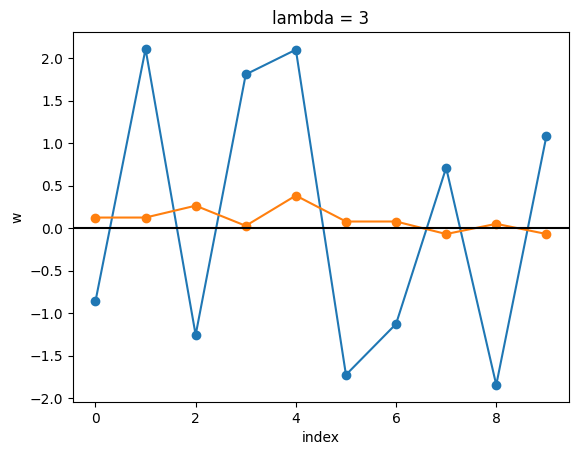

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/traitlets/config/application.py", line 1043, in launch_instance
    app.start()
  File "/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 725, in start
    self.io_loop.start()
  File "/home/artem/git/sdafe/.venv/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
    self.asyncio_loop.run_forever()
  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
    self._run_once()
  File "/usr/local/lib/python3.11/asyncio/base_events.py", line 1907, in _run_once
    handle = self._ready.popleft()
             ^^^^^^^^^^^^^^^^^^^^^
IndexError: pop from an empty deq

In [85]:
fig, ax = plt.subplots()
ax.plot(w_model_free, 'o-', label='model-free');
ax.plot(w_Capm, 'o-', label='CAPM');
ax.axhline(0, color='black');
ax.set_xlabel('index');
ax.set_ylabel('w');
ax.set_title('lambda = 3');